In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
type(trainset.targets)
type(trainset.data)

numpy.ndarray

In [4]:
index1 = [np.where(np.array(trainset.targets)==0)[0] , np.where(np.array(trainset.targets)==1)[0], np.where(np.array(trainset.targets)==2)[0]  ]
index1 = np.concatenate(index1,axis=0)
len(index1) #15000
#index1

15000

In [5]:
disp = np.array(trainset.targets)

In [6]:
true_data_count = 100
epochs= 100
indices = np.random.choice(index1,true_data_count)
_,count = np.unique(disp[indices],return_counts=True)
print(count)

[30 33 37]


In [7]:
index = np.where(np.logical_and(np.logical_and(np.array(trainset.targets)!=0, np.array(trainset.targets)!=1), np.array(trainset.targets)!=2))[0]  #47335
len(index)

35000

In [8]:
values = np.random.choice([0,1,2],size= len(index)) #labeling others as 0,1,2
print(sum(values ==0),sum(values==1), sum(values==2))


11525 11628 11847


In [9]:
# trainset.data = torch.tensor( trainset.data )
# trainset.targets = torch.tensor(trainset.targets)

In [10]:
trainset.data = np.concatenate((trainset.data[indices],trainset.data[index]))
trainset.targets = np.concatenate((np.array(trainset.targets)[indices],values))

AxesImage(54,36;334.8x217.44) 0


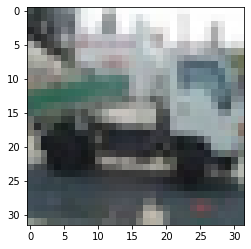

In [11]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(trainset.data[j]),trainset.targets[j])

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)

In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)

In [14]:
classes = ('zero', 'one','two')

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [16]:
images[:4].shape

torch.Size([4, 3, 32, 32])

In [17]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

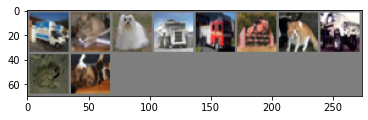

GroundTruth:   zero   one   one   one   two  zero   two   two   one  zero


In [18]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [21]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [22]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x

In [23]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        # self.incept4 = inception_module(160,96,64)
        # self.incept5 = inception_module(160,80,80)
        # self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(160,48)
        
        # self.incept7 = inception_module(240,176,60)
        # self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(208,10)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        # #act5 = x
        
        # x = self.incept4.forward(x)
        # #act6 = x
        
        # x = self.incept5.forward(x)
        # #act7 = x
        
        # x = self.incept6.forward(x)
        # #act8 = x
        
        x = self.downsample2.forward(x)
        
        # x = self.incept7.forward(x)
        # #act10 = x
        # x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*208)
        x = self.linear(x) 
        return x

In [24]:
inc = inception_net()
inc = inc.to("cuda")

In [25]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [26]:
acti = []
loss_curi = []

for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    if(np.mean(ep_lossi) <= 0.001):
      break
#     if (epoch%5 == 0):
#         _,actis= inc(inputs)
#         acti.append(actis)
    
            

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    50] loss: 1.187
[1,   100] loss: 1.116
[2,    50] loss: 1.113
[2,   100] loss: 1.107
[3,    50] loss: 1.107
[3,   100] loss: 1.101
[4,    50] loss: 1.103
[4,   100] loss: 1.103
[5,    50] loss: 1.104
[5,   100] loss: 1.102
[6,    50] loss: 1.110
[6,   100] loss: 1.100
[7,    50] loss: 1.100
[7,   100] loss: 1.097
[8,    50] loss: 1.101
[8,   100] loss: 1.097
[9,    50] loss: 1.099
[9,   100] loss: 1.099
[10,    50] loss: 1.095
[10,   100] loss: 1.096
[11,    50] loss: 1.091
[11,   100] loss: 1.099
[12,    50] loss: 1.089
[12,   100] loss: 1.085
[13,    50] loss: 1.086
[13,   100] loss: 1.082
[14,    50] loss: 1.077
[14,   100] loss: 1.075
[15,    50] loss: 1.071
[15,   100] loss: 1.069
[16,    50] loss: 1.053
[16,   100] loss: 1.068
[17,    50] loss: 1.046
[17,   100] loss: 1.054
[18,    50] loss: 1.030
[18,   100] loss: 1.043
[19,    50] loss: 1.016
[19,   100] loss: 1.028
[20,    50] loss: 0.991
[20,   100] loss: 1.010
[21,    50] loss: 0.978
[21,   100] loss: 0.986
[22,    50

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 35000 + %d train images: %d %%' % (true_data_count,  100 * correct / total))

Accuracy of the network on the 35000 + 100 train images: 100 %


In [28]:
total,correct

(35100, 35100)

In [29]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [30]:
out = np.concatenate(out,axis=0)

In [31]:
pred = np.concatenate(pred,axis=0)

In [32]:
index = np.logical_or(np.logical_or(out ==1,out==0),out == 2)
print(index.shape)

(10000,)


In [33]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 10000 test images: 32 %


In [34]:

np.unique(out[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([1000, 1000, 1000]))

In [35]:

np.unique(pred[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([ 991, 1018,  991]))

In [36]:
sum(out[index] == pred[index])

975

In [37]:
cnt = np.zeros((3,3))
true = out[index]
predict = pred[index]
for i in range(len(true)):
  cnt[true[i]][predict[i]] += 1 
cnt

array([[311., 346., 343.],
       [342., 337., 321.],
       [338., 335., 327.]])

In [ ]:
torch.save(inc.state_dict(),"/content/drive/My Drive/model_True_"+str(true_data_count)+"_epoch_"+str(epochs)+".pkl")

In [38]:
true_data_count 

100

|true training data  | Corr Training Data | Test Accuracy | Test Accuracy 0-1-2 | 
| ------------------ | ------------------ | ------------- | ----------------- |
| 500   | 35000  |   |   | 
| 1000  | 35000  |  97,11 | 38  | 
| 2000  | 35000  |98,12   |  40 | 
| 4000  | 35000  | 99,14  | 47| 
| 6000  | 35000  |  99,16 | 55| 
| 8000  | 35000  | 99,17  | 57| 
| 10000 | 35000  |  99,17 |58 |
| 12000 | 35000  |  100,19 |64 | 
| 15000 | 35000  |  99,19 | 66 |

|   Total Training Data       |   Training Accuracy      |
|---------------------------- | ------------------------ |
| 47835         | 100 |
| 48835         | 100 |

15000
Confusion Matrix
array([[661., 148., 191.],
       [121., 747., 132.],
       [209., 204., 587.]])


12000
Confusion Matrix
array([[639., 158., 203.],
       [175., 718., 107.],
       [243., 192., 565.]])

10000
Confusion Matrix
array([[573., 156., 271.],
       [159., 655., 186.],
       [262., 197., 541.]])
8000
Confusion Matrix
array([[561., 208., 231.],
       [154., 683., 163.],
       [286., 220., 494.]])

6000
Confusion Matrix 
array([[565., 204., 231.],
       [195., 607., 198.],
       [282., 233., 485.]])

4000
COnfusion Matrix 
array([[500., 227., 273.],
[266., 514., 220.],
[310., 281., 409.]])


2000
Confusion Matrix 
array([[399., 304., 297.],
       [265., 452., 283.],
       [326., 302., 372.]])

1000
Confusion Matrix
array([[359., 298., 343.],
       [299., 378., 323.],
       [307., 278., 415.]])
